In [ ]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import imageio

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Specify transforms using torchvision.transforms as transforms library


transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_set = datasets.ImageFolder("/content/drive/MyDrive/dataset/Training", transform = transformations)
val_set = datasets.ImageFolder("/content/drive/MyDrive/dataset/Testing", transform = transformations)

In [ ]:
len(val_set)

539

In [ ]:
len(train_set)

1244

In [ ]:
class_names  = train_set.classes

In [ ]:
# Creating Data_Loader with a batch size of 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size =32, shuffle=True)

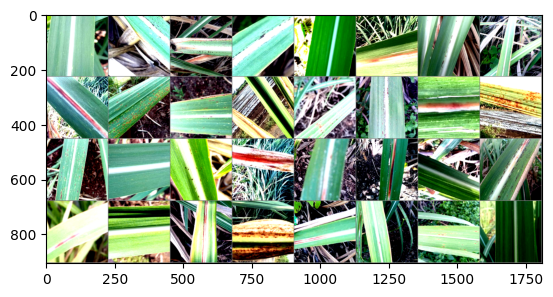

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
imshow(torchvision.utils.make_grid(images))

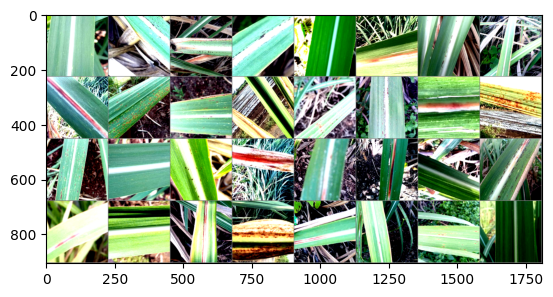

In [ ]:
for images, labels in train_loader:
    # Show images
    imshow(torchvision.utils.make_grid(images))
    break  # Exit loop after one iteration to get only one batch of images and labels


In [ ]:
model = models.resnet50(pretrained= True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 100MB/s] 


In [ ]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#Using the pretrained model we Dont Train the initial layers.
for param in model.parameters():
    param.requires_grad = True #Set True to train the whole network

In [ ]:

# Creating final fully connected Layer that accorting to the no of classes we require
# When training the complete model on our own dataset , we omit the the following sequential layer
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512,len(class_names)),
                                 nn.LogSoftmax(dim=1))

# Loss and optimizer
criterion = nn.NLLLoss()
#optimizer = optim.SGD(model.fc.parameters(), lr=0.01)

In [ ]:
optimizer = optim.SGD([
        {'params': model.conv1.parameters(), 'lr':1e-4},
        {'params': model.layer1.parameters(), 'lr':1e-4},
        {'params': model.layer2.parameters(),'lr':1e-4},
        {'params': model.layer3.parameters(),'lr':1e-3},
        {'params': model.layer4.parameters() ,'lr':1e-3},
        {'params': model.fc.parameters(), 'lr': 1e-2}   # the classifier needs to learn weights faster
    ], lr=0.001, weight_decay=0.0005)

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

In [ ]:
# Restarts the learning rate after every 5 epoch
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0= 5,
        T_mult= 1,
    )

In [ ]:
epochs = 5
best_acc = 0.0
iters = len(train_loader)

In [ ]:
train_loss, val_loss = [], []

In [ ]:
import matplotlib.pyplot as plt
import time

# Initialize lists to store training and validation loss
train_loss = []
val_loss = []

for epoch in range(epochs):

    train_loss_epoch = 0
    valid_loss_epoch = 0
    accuracy = 0

    # Training the model
    model.train()
    running_loss = 0.0
    running_corrects = 0
    start_time = time.time()
    for i, (inputs, labels) in enumerate(train_loader, 1):
        # Move inputs and labels to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Clear gradients
        optimizer.zero_grad()
        model.to(device)
        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        # Add the loss to the training set's running loss
        running_loss += loss.item() * inputs.size(0)

        # Calculate accuracy
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    # Calculate epoch loss and accuracy
    epoch_loss = running_loss / len(train_set)
    epoch_acc = running_corrects.double() / len(train_set)
    train_loss.append(epoch_loss)
    print(f'Epoch {epoch+1}/{epochs}')
    print(f'{len(train_loader)}/{len(train_loader)} [==============================]', end='')
    print(f' - {time.time() - start_time:.0f}s/step', end='')
    print(f' - loss: {epoch_loss:.4f} - accuracy: {epoch_acc:.4f}', end='')

    # Evaluating the model
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    # Tell torch not to calculate gradients
    with torch.no_grad():

        for inputs, labels in val_loader:
            # Move inputs and labels to device
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            val_loss_batch = criterion(outputs, labels)

            # Add loss to the validation set's running loss
            valid_loss_epoch += val_loss_batch.item() * inputs.size(0)

    # Calculate average validation loss
    epoch_val_loss = valid_loss_epoch / len(val_set)
    val_loss.append(epoch_val_loss)

    print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')


Epoch 1/5
39/39 [==============================] - 1192s/step - loss: 1.0089 - accuracy: 0.5780Epoch [1/5], Training Loss: 1.0089, Validation Loss: 0.8964
Epoch 2/5
39/39 [==============================] - 955s/step - loss: 0.7713 - accuracy: 0.8143Epoch [2/5], Training Loss: 0.7713, Validation Loss: 0.6804
Epoch 3/5
39/39 [==============================] - 941s/step - loss: 0.5400 - accuracy: 0.8818Epoch [3/5], Training Loss: 0.5400, Validation Loss: 0.4991
Epoch 4/5
39/39 [==============================] - 953s/step - loss: 0.3759 - accuracy: 0.9100Epoch [4/5], Training Loss: 0.3759, Validation Loss: 0.3811
Epoch 5/5
39/39 [==============================] - 957s/step - loss: 0.2722 - accuracy: 0.9349Epoch [5/5], Training Loss: 0.2722, Validation Loss: 0.3234


In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')

# Load the trained model
model.load_state_dict(torch.load('trained_model.pth'))
model.eval()

# Testing the model
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total}%')


Accuracy of the network on the test images: 90.72356215213358%


In [ ]:
import torchvision.transforms as transforms
from PIL import Image

# Define image transformations
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the input image
input_image = Image.open('/content/drive/MyDrive/rust (365).jpeg')  # Change 'input_image.jpg' to the path of your input image
input_tensor = image_transforms(input_image)
input_batch = input_tensor.unsqueeze(0)  # Add batch dimension


In [ ]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)
    probabilities = torch.exp(output)
    predicted_class = torch.argmax(probabilities).item()

# Get the predicted class label
predicted_label = class_names[predicted_class]
print('Predicted Class:', predicted_label)

Predicted Class: Red Rust
